In [97]:
# Ensure the project root is in PATH.
import sys

sys.path.append("../")
# All imports of our code are relative to the project root.

from backtester.engine import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sys
import os


# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output

In [98]:
market_data_round_4_day_1 = pd.read_csv(os.path.join("..", "data", "round4", "prices_round_4_day_1.csv"), sep=";")
market_data_round_4_day_2 = pd.read_csv(os.path.join("..", "data", "round4", "prices_round_4_day_2.csv"), sep=";")
market_data_round_4_day_3 = pd.read_csv(os.path.join("..", "data", "round4", "prices_round_4_day_3.csv"), sep=";")

trades_round_4_day_1 = pd.read_csv(os.path.join("..", "data", "round4", "trades_round_4_day_1.csv"), sep=";")
trades_round_4_day_2 = pd.read_csv(os.path.join("..", "data", "round4", "trades_round_4_day_2.csv"), sep=";")
trades_round_4_day_3 = pd.read_csv(os.path.join("..", "data", "round4", "trades_round_4_day_3.csv"), sep=";")

observations_round_4_day_1 = pd.read_csv(os.path.join("..", "data", "round4", "observations_round_4_day_1.csv"), sep=",")
observations_round_4_day_2 = pd.read_csv(os.path.join("..", "data", "round4", "observations_round_4_day_2.csv"), sep=",")
observations_round_4_day_3 = pd.read_csv(os.path.join("..", "data", "round4", "observations_round_4_day_3.csv"), sep=",")

market_data_round_4_all3days = concatenate_historical_data([market_data_round_4_day_1, market_data_round_4_day_2, market_data_round_4_day_3])
trades_round_4_all3days = concatenate_historical_data([trades_round_4_day_1, trades_round_4_day_2, trades_round_4_day_3])
observations_round_4_all3days = concatenate_historical_data([observations_round_4_day_1, observations_round_4_day_2, observations_round_4_day_3])

In [99]:
md_all = market_data_round_4_day_3.copy()
th_all = trades_round_4_day_3.copy()
obs_all = observations_round_4_day_3.copy()


np.unique(md_all['product'])

array(['CROISSANTS', 'DJEMBES', 'JAMS', 'KELP', 'MAGNIFICENT_MACARONS',
       'PICNIC_BASKET1', 'PICNIC_BASKET2', 'RAINFOREST_RESIN',
       'SQUID_INK', 'VOLCANIC_ROCK', 'VOLCANIC_ROCK_VOUCHER_10000',
       'VOLCANIC_ROCK_VOUCHER_10250', 'VOLCANIC_ROCK_VOUCHER_10500',
       'VOLCANIC_ROCK_VOUCHER_9500', 'VOLCANIC_ROCK_VOUCHER_9750'],
      dtype=object)

In [100]:
def get_time_part(df: pd.DataFrame, l, h) -> pd.DataFrame:
    dfret = df.copy()
    dfret = dfret[(dfret["timestamp"] >= l) & (dfret["timestamp"] < h)].reset_index(drop=True)
    return dfret


def get_sunlight_part(
    md: pd.DataFrame, th: pd.DataFrame, obs: pd.DataFrame, low: float, high: float
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Return three DataFrames (md_slice, th_slice, obs_slice) containing
    only the rows whose timestamps fall into the obs rows where
    sunlightIndex is in [low, high).
    """
    # 1) find all timestamps where sunlight is in the desired band
    mask = (obs["sunlightIndex"] >= low) & (obs["sunlightIndex"] < high)
    ts = obs.loc[mask, "timestamp"]

    # 2) slice each DataFrame by those timestamps
    md_slice = md[md["timestamp"].isin(ts)].reset_index(drop=True)
    th_slice = th[th["timestamp"].isin(ts)].reset_index(drop=True)
    obs_slice = obs.loc[mask].reset_index(drop=True)

    return md_slice, th_slice, obs_slice


Correlation: 0.9387645849526538


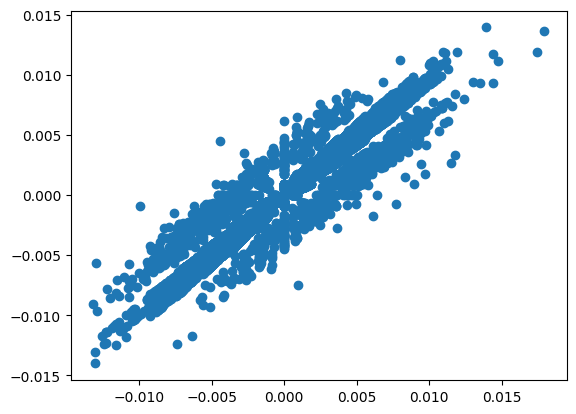

In [ ]:
KELP = "KELP"
SQUID_INK = "SQUID_INK"
MAGNIFICENT_MACARONS = "MAGNIFICENT_MACARONS"


# md_kelp = md_all[md_all["product"] == KELP].reset_index()
# md_squink = md_all[md_all["product"] == SQUID_INK].reset_index()
md_macaron = md_all[md_all["product"] == MAGNIFICENT_MACARONS].reset_index()

def logreturn(series):
    return np.log(series) - np.log(series).shift(1)

# kelp_r = logreturn(md_kelp['mid_price'])
# squink_r = logreturn(md_squink['mid_price'])
macaron_r = logreturn(md_macaron['mid_price'])
sugar_r = logreturn(obs_all['bidPrice'])


df_align = pd.DataFrame({
    "macaron_r": macaron_r,
    "sugar_r": sugar_r,
    'timestamp': md_all['timestamp']
}).dropna()


df_align = get_time_part(df_align, 0, 2e5)
df_align.to_csv("dfal.csv")
plt.scatter(df_align['macaron_r'], df_align['sugar_r'])


correlation = df_align["macaron_r"].corr(df_align["sugar_r"])
print("Correlation:", correlation)



